# VAE

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE
# from LossFunction import SSIMLoss #自作Loss関数
import LossFunction

## 学習データ作成

In [39]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("sample_data", "sample_test", 1000, 512, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (1000, 512, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


## モデル作成

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

In [40]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)
        std = torch.std(x, (0, 2, 3), keepdim=True)
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5
        return self.gamma * x_normalized + self.beta

## モデル作成

## モデル学習

Denoise AE


In [41]:

losslist=[]

model = mainmodel.Autoencoder_batchnorm()
# criterion = nn.MSELoss()
criterion = LossFunction.SSIMLoss_edit()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

outputs = []
#テンソル型に変換
data = torch.from_numpy(data.astype(np.float32)).clone()
ori_data = torch.from_numpy(ori_data.astype(np.float32)).clone()
for (epoch, epoch_ori) in zip(data, ori_data):
    for (data, data_ori) in zip(epoch, epoch_ori):
        recon = model(data)
        # print("type:recon_data{}".format(type(recon)))
        loss = criterion(recon, data_ori)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#     print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    # print('Loss:{:.4f}'.format(float(loss)))
    losslist.append(loss)
    outputs.append((epoch, data, recon))

Normal

In [42]:

# losslist=[]

# model = mainmodel.Autoencoder_batchnorm()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

# outputs = []
# #テンソル型に変換
# data = torch.from_numpy(data.astype(np.float32)).clone()
# ori_data = torch.from_numpy(ori_data.astype(np.float32)).clone()
# for epoch in data:
#     for data in epoch:
#         recon = model(data)
#         # print("type:recon_data{}".format(type(recon)))
#         loss = criterion(recon, data)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

# #     print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
#     # print('Loss:{:.4f}'.format(float(loss)))
#     losslist.append(loss)
#     outputs.append((epoch, data, recon))

In [43]:
# z_dim = 8
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = modelVAE.VAE_cnn(z_dim, device).to(device)
# # optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
# input_data = torch.from_numpy(data.astype(np.float32)).clone()
# input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()
# for epoch in input_data:
#     losses = []
#     KL_losses = []
#     reconstruction_losses = []
#     model.train()
#     for x in epoch:
#         x = x.to(device)
#         model.zero_grad()
#         KL_loss, reconstruction_loss = model.loss(x)  # lossの各項の計算
#         loss = KL_loss + reconstruction_loss  # 和を取ってlossとする
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.detach().numpy())
#         KL_losses.append(KL_loss.detach().numpy())
#         reconstruction_losses.append(reconstruction_loss.detach().numpy())

#     losses_val = []
#     model.eval()
#     # for x in input_test_data:
#     #     KL_loss, reconstruction_loss = model.loss(x)
#     #     loss = KL_loss + reconstruction_loss
#     #     losses_val.append(loss.cpu().detach().numpy())

#     # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
#     #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

## モデルの保存

In [44]:
model_name = "AE_Batch_MSSIMedit"
ModelEdit = mainmodel.Modeledit("AE_Batch_SSIM")
ModelEdit.save_model(model, model_name) 

## 確認だよーん

In [45]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("sample_data", "sample_test", 1000, 512, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (1000, 512, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


<class 'torch.Tensor'>


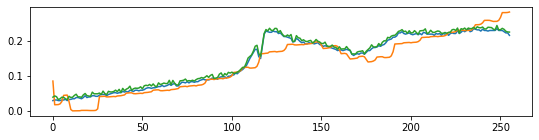

normal:4.523040456697345


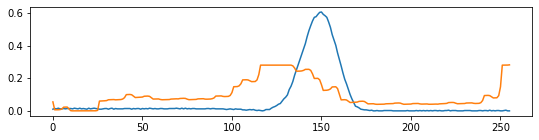

anomarly:25.343084923923016
anomaly
<class 'torch.Tensor'>


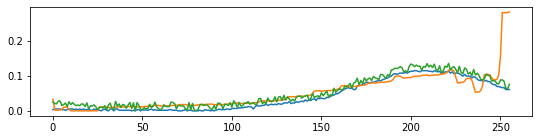

normal:4.177421199856326


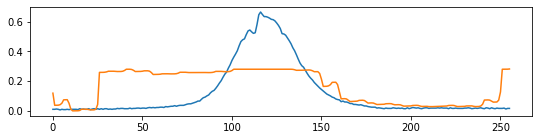

anomarly:29.44027379900217
anomaly
<class 'torch.Tensor'>


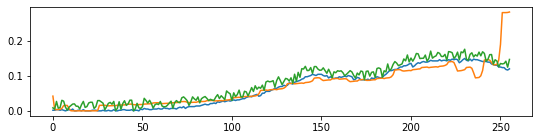

normal:3.5822415378775077


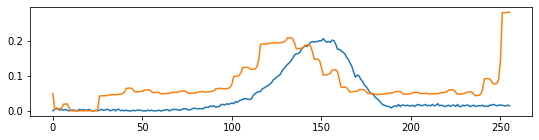

anomarly:13.324441814535021
anomaly
<class 'torch.Tensor'>


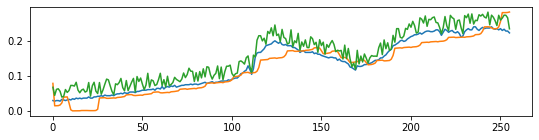

normal:4.329322120174766


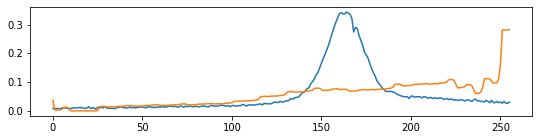

anomarly:11.851191014284268
anomaly
<class 'torch.Tensor'>


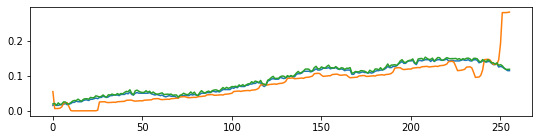

normal:4.648981018923223


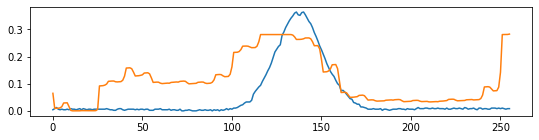

anomarly:18.989707882050425
anomaly


IndexError: index 50 is out of bounds for axis 0 with size 50

In [46]:
# num = 5

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        input0 =  torch.from_numpy((data[i]).astype(np.float32)).clone()
        ori_input0 =  torch.from_numpy((ori_data[i]).astype(np.float32)).clone()
        # ori_input0 =  ori_data[i]
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        print(type(data0))
        plt.figure(figsize=(9, 2))
        # data = data0.numpy()
        ori_input0 = ori_input0[i, :, :, :]
        input0 = input0[i, :, :, :]
        recon = model(ori_input0).detach().numpy()
        ori_input0 = ori_input0[0, 0, :]
        input0 = input0[0, 0, :]
        plt.plot(ori_input0)
        plt.plot(recon.flatten())
        plt.plot(input0)
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-ori_input0.numpy()))
        print("normal:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")
            
        plt.figure(figsize=(9, 2))
        # data = test0.numpy()
        ano_data = test0[np.newaxis, np.newaxis, :]
        recon = model(ano_data).detach().numpy()
        plt.plot(test0.numpy(),label="testdata")
        plt.plot(recon.flatten(),label="recondata")
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
        print("anomarly:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")

In [ ]:
data[2]

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols=5, figsize=(20,12))
model.eval()
for r in range(3):
    for c in range(5):
        ax[r,c].imshow(model.decoder(torch.randn(10).cuda()).detach().cpu().numpy().reshape(28,28), cmap="gray")
        ax[r,c].axis("off")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve

In [ ]:
import dataloader

Dataset = dataset.dataset("Obrid_AE", "data")
data, test_data , anomaly_data= Dataset.read_traindata_ocs("sample_data", "sample_test", 1000, 256, 1)

input_model = mainmodel.Autoencoder2()
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_model = mainmodel.Autoencoder2().to(device)
input_model.load_state_dict(torch.load("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211206/newmodel.pth", map_location=device))

# input_model = model

recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(model, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(model, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(model, anomaly_data)

In [ ]:
from sklearn.svm import OneClassSVM

X_anomaly = anomaly_encoded_list
X_test = test_encoded_list
X_train = encoded_list

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from sklearn import svm
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

SPACE_SAMPLING_POINTS = 100
TRAIN_POINTS = 100

# Define the size of the space which is interesting for the example
X_MIN = -100
X_MAX = 100
Y_MIN = -100
Y_MAX = 100
Z_MIN = -100
Z_MAX = 100

# Generate a regular grid to sample the 3D space for various operations later
xx, yy, zz = np.meshgrid(np.linspace(X_MIN, X_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Y_MIN, Y_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Z_MIN, Z_MAX, SPACE_SAMPLING_POINTS))

# Generate some abnormal novel observations using a different distribution
X_outliers = np.random.uniform(low=-10, high=10, size=(20, 3))

# Create a OneClassSVM instance and fit it to the data
clf = svm.OneClassSVM(nu=0.009, kernel="rbf", gamma=0.8)
clf.fit(X_train)
# Predict the class of the various input creaxted before
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_anomaly = clf.predict(X_anomaly)
# y_pred_normal = clf.predict(X_anomaly)
y_pred_outliers = clf.predict(X_outliers)
print("y_pred_train:{} ".format(y_pred_train.shape[0] ))
print("y_pred_anomaly:{} ".format(y_pred_anomaly ))
print("y_pred_outliers:{} ".format(y_pred_outliers ))
# And compute classification error frequencies
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_anomaly = y_pred_anomaly[y_pred_anomaly == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
error_train = y_pred_train[y_pred_train == -1]
error_anomaly = y_pred_anomaly[y_pred_anomaly == -1]
error_test = y_pred_test[y_pred_test == 1]
# Calculate the distance from the separating hyperplane of the SVM for the
# whole space using the grid defined in the beginning
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)

# Create a figure with axes for 3D plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle("Novelty Detection")

# Plot the different input points using 3D scatter plotting
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='white', alpha=0.5)
# ax.scatter(error_train[:, 0],error_train[:, 1], error_train[:, 2], c='black', alpha=0.5)
b2 = ax.scatter(X_anomaly[:, 0], X_anomaly[:, 1], X_anomaly[:, 2], c='yellow', alpha=0.5)
# ax.scatter(error_anomaly[:, 0],error_anomaly[:, 1], error_anomaly[:, 2], c='red', alpha=0.5)
c = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='cyan', alpha=0.5)
# ax.scatter(error_test[:, 0],error_test[:, 1], error_test[:, 2], c='magenta', alpha=0.5)
# Plot the separating hyperplane by recreating the isosurface for the distance
# == 0 level in the distance grid computed through the decision function of the
# SVM. This is done using the marching cubes algorithm implementation from
# scikit-image.
# verts, faces = measure.marching_cubes(Z, 0)
# # Scale and transform to actual size of the interesting volume
# verts = verts * \
#     [X_MAX - X_MIN, Y_MAX - Y_MIN, Z_MAX - Z_MIN] / SPACE_SAMPLING_POINTS
# verts = verts + [X_MIN, Y_MIN, Z_MIN]
# # and create a mesh to display
# mesh = Poly3DCollection(verts[faces],
#                         facecolor='orange', edgecolor='gray', alpha=0.3)
# ax.add_collection3d(mesh)

# # Some presentation tweaks
# ax.set_xlim((-5, 5))
# ax.set_ylim((-5, 5))
# ax.set_zlim((-5, 5))

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.legend([mpatches.Patch(color='orange', alpha=0.3), b1, b2, c],
#     ["learned frontier", "training observations",
#     "new regular observations", "new abnormal observations"],
#     loc="lower left",
#     prop=matplotlib.font_manager.FontProperties(size=11))
ax.set_title(
    "error train: %d/%d ; errors anomaly: %d/%d ; "
    "error test: %d/%d "
    % (n_error_train, X_train.shape[0], n_error_anomaly, X_anomaly.shape[0], n_error_test, X_test.shape[0]))
fig.show()